# **IDENTIFIKASI VEGETASI OTOMATIS DENGAN GAMBAR GOOGLE EARTH MENGGUNAKAN CONVOLUTIONAL NEURAL NETWORK** 

# Preferensi

Penelitian Sebelumnya :
**Metode Convolutional Neural Network pada Gambar Google Earth Hutan Bambu di Jepang dengan .** 

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

link sebagai berikut : https://doi.org/10.1101/351643

**Note**

Penelitian ini mengambil konsep dari peneliti asal Jepang yang mengidentifikasikan vegatasi akurasi tinggi lahan hutan bamboo di beberapa wilayah Jepang, dengan klasisfikasi CNN, dan dilakukan dengan metode chopped-image.

Sedangkan pada penelitian ini memiliki konsep yang serupa dengan penelitian sebelumnya, akan tetapi studi kasus dilakukan lahan persawahan di Kabupaten Banyumas. 

Peneliti : Fendy Prayogi

Repositori tersedia pada : https://github.com/Gio1709/paddy


# Mengimpor/Mengambil Fungsi Library

In [1]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Mendownload Dataset dari Github

In [2]:
# Mendownload datasheet dari github dan mengekstrak file
!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
!unzip -P paddy paddy.zip


--2019-11-23 16:17:18--  https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13362211 (13M) [application/zip]
Saving to: ‘paddy.zip’

paddy.zip           100%[===================>]  12.74M  --.-KB/s    in 0.08s   

2019-11-23 16:17:18 (155 MB/s) - ‘paddy.zip’ saved [13362211/13362211]

--2019-11-23 16:17:18--  http://paddy.zip/
Resolving paddy.zip (paddy.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘paddy.zip’
FINISHED --2019-11-23 16:17:18--
Total wall clock time: 0.6s
Downloaded: 1 files, 13M in 0.08s (155 MB/s)
Archive:  paddy.zip
   creating: paddy/
  inflating: paddy/bamboopaddy_forest_detection.ipynb  
   creating: paddy/chopped/
   creating: paddy/test/
  inflat

**Persiapan :**

*Program ini dibuat untuk mengidentifikasi lahan sawah dan luas di Kabupaten Banyumas*

File tersimpan dalam folder :
1. */chopped*
2. */train*
3. */test* 

# Mengimpor Datasheet

In [3]:
#Perintah untuk melihat list bagian dari file yang sudah diunduh dari Github

!ls paddy/train
#gambar dengan nama awalan dengan "b" adalah gambar yang terdapat padi"
#gambar dengan nama awalan dengan "o" adalah gambar yang tidak terdapat padi"

b10.jpg  b24.jpg  b38.jpg  b51.jpg  b65.jpg  b79.jpg  o10.jpg  o24.jpg	o38.jpg
b11.jpg  b25.jpg  b39.jpg  b52.jpg  b66.jpg  b7.jpg   o11.jpg  o25.jpg	o39.jpg
b12.jpg  b26.jpg  b3.jpg   b53.jpg  b67.jpg  b80.jpg  o12.jpg  o26.jpg	o3.jpg
b13.jpg  b27.jpg  b40.jpg  b54.jpg  b68.jpg  b81.jpg  o13.jpg  o27.jpg	o40.jpg
b14.jpg  b28.jpg  b41.jpg  b55.jpg  b69.jpg  b82.jpg  o14.jpg  o28.jpg	o4.jpg
b15.jpg  b29.jpg  b42.jpg  b56.jpg  b6.jpg   b83.jpg  o15.jpg  o29.jpg	o5.jpg
b16.jpg  b2.jpg   b43.jpg  b57.jpg  b70.jpg  b84.jpg  o16.jpg  o2.jpg	o6.jpg
b17.jpg  b30.jpg  b44.jpg  b58.jpg  b71.jpg  b85.jpg  o17.jpg  o30.jpg	o7.jpg
b18.jpg  b31.jpg  b45.jpg  b59.jpg  b72.jpg  b86.jpg  o18.jpg  o31.jpg	o8.jpg
b19.jpg  b32.jpg  b46.jpg  b5.jpg   b73.jpg  b87.jpg  o19.jpg  o32.jpg	o9.jpg
b1.jpg	 b33.jpg  b47.jpg  b60.jpg  b74.jpg  b88.jpg  o1.jpg   o33.jpg
b20.jpg  b34.jpg  b48.jpg  b61.jpg  b75.jpg  b89.jpg  o20.jpg  o34.jpg
b21.jpg  b35.jpg  b49.jpg  b62.jpg  b76.jpg  b8.jpg   o21.jpg  o35.jpg
b22.jp

#Menampilkan Gambar Pelatihan

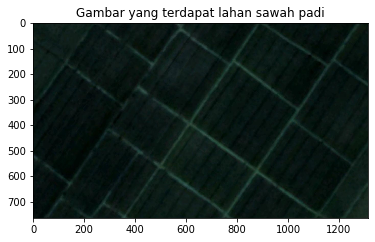

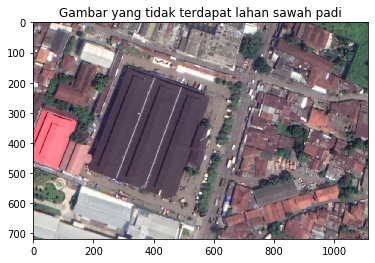

In [4]:
#Gambar yang terdapat lahan sawah padi
plt.title("Gambar yang terdapat lahan sawah padi")
plt.imshow(imread("paddy/train/b2.jpg"))
plt.show()

#Gambar yang terdapat tidak lahan sawah padi
plt.title("Gambar yang tidak terdapat lahan sawah padi")
plt.imshow(imread("paddy/train/o10.jpg"))
plt.show()


# Membuat "patches" dari setiap gambar menggunakan metode sliding window

**Apa itu *Sliding Window* ?**

*Sliding window* adalah window yang bergeser untuk memprediksi dan mencari area objek yang benar. Suatu proses deteksi objek memerlukan teknik lokalisasi 
untuk menemukan area objek. 



In [5]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #Membaca gambar path penyimpanan window ke direktori/file yang spesifik
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".jpg"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)

##Mengembalikan daftar gambar train pada direktori
files = os.listdir("paddy/train/")
files = [x for x in files if x.endswith(".jpg")]

#Menyimpan gambar yang telah dicacah pada folder chopped
for file in files:
    save_directory = "paddy/chopped"
    file = os.path.join("paddy/train/",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b46_00000.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b46_00001.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b46_00004.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b46_00005.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b46_00006.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b46_00010.jpg is a low contrast image
  warn('%s is

In [6]:
#Mengembalikan daftar gambar yang telah diacak pada direktori
files = os.listdir("paddy/chopped/")
files = [x for x in files if x.endswith(".jpg")]

#Memuat dataset Pelatihan
x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("paddy/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(24841, 56, 56, 3) (24841,)


In [7]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.3,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(17388, 56, 56, 3)
(17388,)
(7453, 56, 56, 3)
(7453,)


In [8]:
#Mengkomputasi kelas bobotnya
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([9124, 8264]))
(array([0, 1]), array([3911, 3542]))
[0.95287155 1.05203291]


# Membuat Pemodelan dan Pelatihan Model

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

#Pembuatan Model

In [9]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.05),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.05),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.05),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    #layers.Dropout(0.05),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 32)        9248      
____________________

#Pelatihan


In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan model bobot yang terbaik selama training
ckpt = ModelCheckpoint("paddy.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(train_x,train_y,batch_size=50,epochs=100,validation_data=(valid_x,valid_y),class_weight=cw, callbacks = [ckpt])




Train on 17388 samples, validate on 7453 samples
Epoch 1/100





17388/17388 [==============================] - 12s 671us/step - loss: 0.1367 - acc: 0.9410 - val_loss: 0.0439 - val_acc: 0.9871

Epoch 00001: val_loss improved from inf to 0.04387, saving model to paddy.h5
Epoch 2/100
17388/17388 [==============================] - 5s 266us/step - loss: 0.0423 - acc: 0.9846 - val_loss: 0.0298 - val_acc: 0.9887

Epoch 00002: val_loss improved from 0.04387 to 0.02982, saving model to paddy.h5
Epoch 3/100
17388/17388 [==============================] - 5s 270us/step - loss: 0.0228 - acc: 0.9920 - val_loss: 0.0306 - val_acc: 0.9883

Epoch 00003: val_loss did not improve from 0.02982
Epoch 4/100
17388/17388 [==============================] - 5s 265us/step - loss: 0.0180 - acc: 0.9942 - val_loss: 0.0302 - val_acc: 0.9879

Epoch 00004: val_loss did not improve from 0.02982
Epoch 5/100
17388/17388 [==============================] - 5s 269us/step - loss: 0.0115 - acc: 0.9964 - val_loss: 0.0087 -

#Menggambarkan Hasil Pelatihan

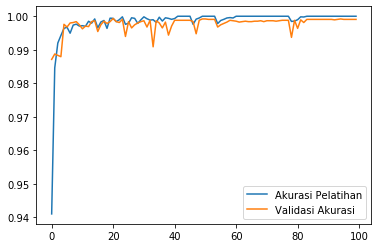

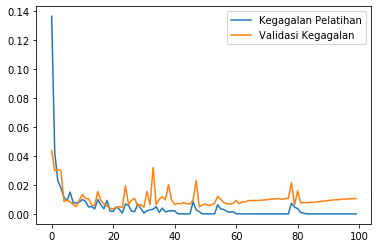

In [11]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kegagalan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kegagalan")
plt.legend()
plt.show()

# Evaluasi Gambar Pelatihan dengan Gambar Test data

In [0]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model.load_weights("paddy.h5")

In [13]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(x= train_x, y = train_y))
#Evaluasi validasi data
print(model.evaluate(x= valid_x, y = valid_y))

['loss', 'acc']
17388/17388 [==============================] - 2s 118us/step
[0.0004066178836523322, 0.9999424890729238]
7453/7453 [==============================] - 1s 121us/step
[0.0033699471197511668, 0.9993291292097142]


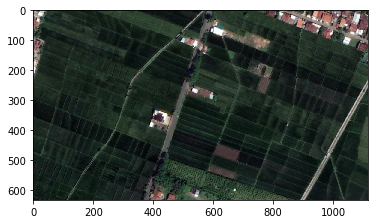

27
1296 27 48


In [32]:
#Membaca Gambar Test Data dan Menampilkannya
img_path = "paddy/test/test_image2.jpg"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#Membuat subimages dengan patches menggunkan metode sliding windows
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#Mengecek total gambar dan banyaknya gambar yang terpasang pada height direction, maupun width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)


#Prediksi Gambar Individual

(1296, 1)
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


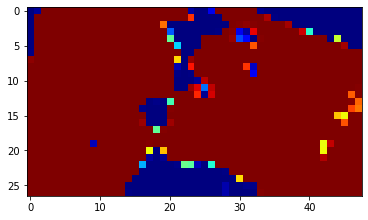

In [33]:
#Memprediksi prpbalititas keberadaaan lahan sawah padi terhadap gambar yang telah dicacah 
#dan kembali pada gambar original
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

**Catatan** :
Bahwa setiap gambar sesuai dengan 1 piksel dari probabilitasnya, dan ukurannya tidak kompatibel dengan gambar input.
Oleh karena itu peneliti akan menghitung faktor rasio dan mengubah ukurannya

In [34]:
#Array pada gambar diperbesar menggunakan interpolasi spline
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

23
(621, 1104)


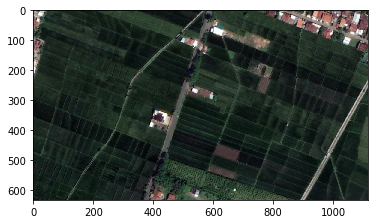

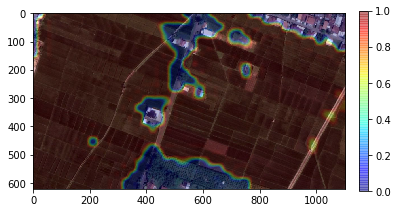

In [35]:
#Menampilkan hasil gambar level tertentu
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()

#Menampilkan Luas Lahan Sawah yang berwarna Merah


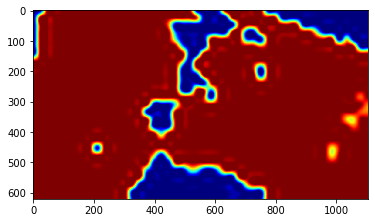

In [36]:
plt.imshow(zoomed,alpha=1,vmax=1.0,vmin=0,cmap="jet")

#Menghitung luas Sawah 


In [37]:
#Menampilkan nilai level zoomed dalam range acak
print("Minimal level zoomed :", np.min(zoomed))
print("Maximal level zoomed :", np.max(zoomed))

Minimal level zoomed : -0.29867545
Maximal level zoomed : 1.249199


In [38]:
#Menampilkan nilai level zoomed dalam range 0 sampai 1
normalized = (zoomed-np.min(zoomed))/(np.max(zoomed)-np.min(zoomed))
print("Minimal level ternomalisasi:", np.min(normalized))
print("Maximal level ternomalisasi:", np.max(normalized))

Minimal level ternomalisasi: 0.0
Maximal level ternomalisasi: 1.0


In [39]:
#Menghitung luas lahan sawah dalam piksel
#Tingkatan level warna dari 0 sampai 1 yang mencapai bentuk sawah adalah 0.5 (Nilai diantara 0 dan 1)
luaspiksel=(normalized>0.5).sum()
print("Luas lahan sawah dalam piksel :", (luaspiksel))

Luas lahan sawah dalam piksel : 581030


**"Validasi Nilai Piksel ke dalam Meter"**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/zoomed%20gambar.jpg)

Dapat dilakukan dengan cara :
1.   Menzoom/memperbesar sampel gambar (sampai batas maksimum).
2.   Menghitung jumlah piksel, sebagai contoh pada objek Bus. Diketahui pada umumnya Bus memiliki lebar sebesar 2,5 Meter. [Resolusi Gambar adalah 1116x632 piksel]
3.   Kalkulasi nilai lebar Bus dalam piksel, disini berjumlah 8 piksel. Lalu dilakukan perhitungan sebagai berikut :
    *   Nilai Meter/Piksel(**M/P**) = **M**(meter) / **P**(piksel)
                           = 2,5 meter / 8 piksel
                           = 0,3125 m/p 
                           ~= 0,3 m/p

Maka konversi 1 piksel menjadi meter pada gambar ini sebesar 0,3 

Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09



**Atau dengan pembanding validitas lainnya, yaitu menggunakan software Google Earth**

![image](https://raw.githubusercontent.com/Gio1709/paddy/master/google%20earth.jpg)

Disini diketahui :
*   Jumlah piksel pada garis berwarna kuning adalah 42 piksel
*   Panjang garis berwarna kuning adalah 14,5 meter

Dengan cara yang sama seprti sebelumnya :
 
 dilakukan perhitungan sebagai berikut :

    *   Nilai Meter/Piksel(M/P) = M(meter) / P(piksel)
                           = 14,5 meter / 42 piksel
                           = 0,323 m/p 
                           ~= 0,3 m/p

In [40]:
#Setelah diketahui luas sawah dalam piksel, kemudian menkonversi dalam meter dan hektar
#Untuk menghitung luas maka dilakukan dengan 0,3 x 0,3 = 0,09 
luasmtr = 0.1089*(luaspiksel)
luasha = (luasmtr)/10000
print("Luas lahan sawah dalam meter persegi :", (luasmtr))
print("Luas lahan sawah dalam hektar :", (luasha))

Luas lahan sawah dalam meter persegi : 63274.167
Luas lahan sawah dalam hektar : 6.327416700000001
